# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2021-10-27 17:50:02.942508: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# **Read and Clean Data**

In [2]:
df=pd.read_csv('../input/tamilsentiment/tamil_sentiment_full.csv' , sep='\t', header=None)
columns_titles = [1,0]
df=df.reindex(columns=columns_titles)
index_names = df[ (df[0] == 'Positive ') | (df[0] == 'not-Tamil') | (df[0] == 'unknown_state') ].index
df.drop(index_names, inplace = True)
df.head()

,1,0
0,Enna da ellam avan seyal Mari iruku,Negative
1,This movei is just like ellam avan seyal,Negative
2,Padam vanthathum 13k dislike pottavaga yellam ...,Positive
3,Neraya neraya neraya... ... V era level...thala,Positive
4,wow thavala sema mass....padam oru pundaikum a...,Positive


In [3]:
df[0].unique()

array(['Negative', 'Positive', 'Mixed_feelings'], dtype=object)

In [4]:
df=df.dropna()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='count'>

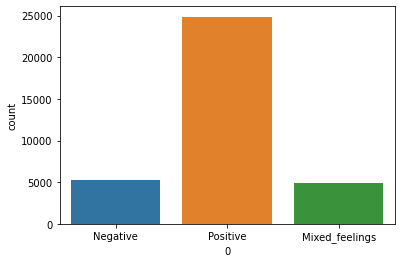

In [5]:
sns.countplot(df[0])

In [6]:
X=df.drop(0,axis=1)
y=df[0]

In [7]:
### Vocabulary size
voc_size=3000

In [8]:
messages=X.copy()
messages.reset_index(inplace=True)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages[1][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [11]:
corpus[:10]

['enna da ellam avan seyal mari iruku',
 'movei like ellam avan seyal',
 'padam vanthathum k dislik pottavaga yellam yea da dislik pannom nu feel pannanum',
 'neraya neraya neraya v era level thala',
 'wow thavala sema mass padam oru pundaikum aagathu',
 'andha k unlik panavangaluku kolandha porakathu',
 'yaarellam frst like pottutu video paaka start paneenga hit like',
 'ethana padam vanthanu salt pepper mattum th l',
 'thala mass hvi sprt kerala surya anna fan',
 'elam avan jayal movi remak pa']

# **Process Input/Output**

In [12]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [13]:
#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))
print(l)

80


In [14]:
sent_length=35
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2673  383 2650]
 [   0    0    0 ... 2463 1391 2673]
 [   0    0    0 ...  142  159  449]
 ...
 [   0    0    0 ... 2982 2515    8]
 [   0    0    0 ... 1481   46 2535]
 [   0    0    0 ... 2090 1002 2739]]


In [15]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 2857, 2951, 2463, 1391, 2673,
        383, 2650], dtype=int32)

# **Create and Train Model**

In [16]:
# Creating model
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
model.summary()

2021-10-27 17:50:49.918590: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-27 17:50:49.922333: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-27 17:50:49.965085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 17:50:49.965761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-27 17:50:49.965821: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-27 17:50:49.992797: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           300000    
_________________________________________________________________
dropout (Dropout)            (None, 35, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [17]:
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs)
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[1 1 2 ... 2 0 2]


In [18]:
X_final.shape,y_final.shape

((35028, 35), (35028,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

In [30]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=60,batch_size=256,callbacks = [model_save])

Epoch 1/60
99/99 [==============================] - 2s 16ms/step - loss: 0.7937 - accuracy: 0.7425 - val_loss: 0.9096 - val_accuracy: 0.6925

Epoch 00001: val_loss improved from inf to 0.90959, saving model to weights.h5
Epoch 2/60
99/99 [==============================] - 1s 13ms/step - loss: 0.7741 - accuracy: 0.7504 - val_loss: 0.8915 - val_accuracy: 0.7142

Epoch 00002: val_loss improved from 0.90959 to 0.89149, saving model to weights.h5
Epoch 3/60
99/99 [==============================] - 1s 12ms/step - loss: 0.7577 - accuracy: 0.7570 - val_loss: 0.9267 - val_accuracy: 0.6939

Epoch 00003: val_loss did not improve from 0.89149
Epoch 4/60
99/99 [==============================] - 1s 13ms/step - loss: 0.7441 - accuracy: 0.7611 - val_loss: 0.9140 - val_accuracy: 0.6996

Epoch 00004: val_loss did not improve from 0.89149
Epoch 5/60
99/99 [==============================] - 1s 12ms/step - loss: 0.7382 - accuracy: 0.7651 - val_loss: 0.9470 - val_accuracy: 0.6957

Epoch 00005: val_loss did 

# **Analysis and Visualisation of output**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


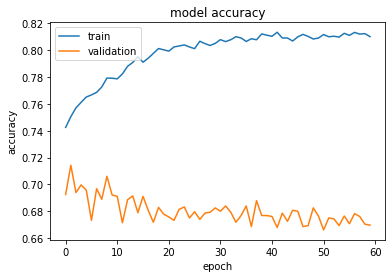

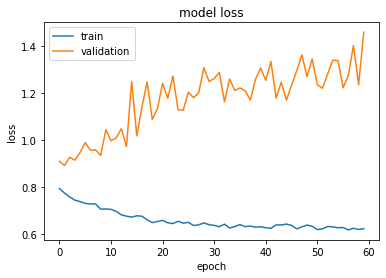

In [31]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
model.load_weights('weights.h5')

In [23]:
y_pred=model.predict_classes(X_test)
print(y_pred)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[2 2 2 ... 2 2 2]


In [34]:
print(accuracy_score(y_test,y_pred))

0.7106765629460462


In [35]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       969
           1    0.00000   0.00000   0.00000      1058
           2    0.71068   1.00000   0.83087      4979

    accuracy                        0.71068      7006
   macro avg    0.23689   0.33333   0.27696      7006
weighted avg    0.50506   0.71068   0.59048      7006



Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


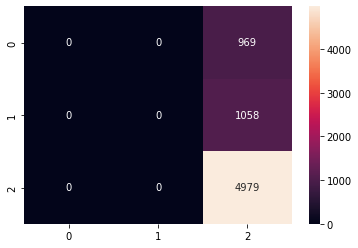

In [37]:
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

# **Prediction Testing**

In [38]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

In [43]:
predict_emotion('padam nalla illa, kevalama iruku')

'Negative'

In [40]:
predict_emotion('padam kola mass')

'Positive'